In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from utils import *
from three_stage_model import *
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
%matplotlib inline

def get_df_for_heuristic():
    df = pd.read_csv("/Users/ashutoshshukla/Desktop/ThreeStageModel/data/192_Scenario/Final_Input1.csv")
    directions = ["w", "wnw", "nw", "nnw", "n", "nne"]
    categories = ["2", "3", "4", "5"]
    forward_speeds = ["05", "10", "15", "25"]
    lister = []
    for i in directions:
        for j in range(len(categories)):
            for k in range(len(forward_speeds)):
                lister.append("max_flood_level_" + i +"_" + categories[j] + "_" + forward_speeds[k])
    df = df[list(df.columns[0:9]) + lister]
    df_sub = df[["SubNum", "load"]].groupby("SubNum").sum()
    df_flood = df[["SubNum"] + lister]
    df_flood = df_flood.drop_duplicates().set_index("SubNum") # drop duplicates
    df_flood = df_flood.loc[(df_flood.sum(axis=1) != 0), :] # drop substations that are not flooded
    """df_sub has load demand for all the substations"""
    """df_flood has only flooded substations"""
    return df, df_sub, df_flood

df, df_sub, df_flood = get_df_for_heuristic()

# Debug

25
first,	 96
Second,	 96


/var/folders/fp/6t_nm_y57cdgtz0cbgyt17nm0000gn/T/ipykernel_28956/3244263018.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 720x360 with 0 Axes>

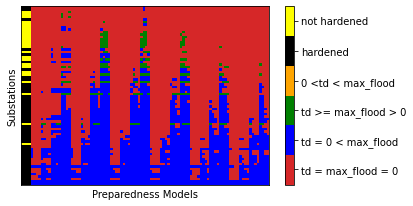

In [35]:
model_name_list = [25]
# model_name_list = [250]

for voll_c in model_name_list:
    print(voll_c)
    # model_name = "vc_" + str(voll_c)
    model_name = "perfect_prediction"
    main_path = "/Users/ashutoshshukla/Downloads/output/" + model_name + "/"

    with open(main_path + "model_params.json", 'r') as f:
        params = json.load(f)   
    params["path_to_input"] = os.getcwd() + "/data/192_Scenario/"

    with open(main_path + "model_scenarios.json", 'r') as f:
        model_scenarios_string = json.load(f)

    model_scenarios = {}
    for k in model_scenarios_string:
        model_scenarios[int(k)] = model_scenarios_string[k]

    base_model = three_stage_model(params, model_scenarios)
    base_model.model.update()
    sol_path = main_path + "solution.sol"
    base_model.model.read(sol_path)
    base_model.model.update()

    hardening_decisions = {}
    tiger_dam_decisions = {}

    for sub_id in df_flood.index:
        hardening_decisions[sub_id] = round(base_model.x_mit[sub_id].Start*params["mit_level"])
    for sub_id in df_flood.index:
        for j in model_scenarios:
            tiger_dam_decisions[str(sub_id) + "_" + str(j)] = round(base_model.x_prep[sub_id,j].Start*params["prep_level"])
    
    print("first,\t", len(model_scenarios.keys()))
    df_plot = pd.DataFrame(index=df_flood.index, columns=np.arange(0,len(model_scenarios.keys()),1))
    
    lister = []
    for i in df_plot.index:
        for j in df_plot.columns:
            temp = str(i) + "_" + str(j)
            td_value = tiger_dam_decisions[temp]
            flood = df_flood.loc[i, model_scenarios[j]].max()
            if td_value == 0:
                if flood == 0:
                    df_plot.loc[i,j] = 0.0
                else:
                    df_plot.loc[i,j] = 1.0
            else:
                if td_value >= flood:
                    df_plot.loc[i,j] = 2.0
                else:
                    df_plot.loc[i,j] = 3.0
        if hardening_decisions[i] > 0:
            lister.append(4.0)
        else:
            lister.append(5.0)

    df_plot["hardening"] = lister
    df_plot["hardening1"] = lister
    df_plot["hardening2"] = lister
    df_plot["hardening3"] = lister
    
    # reorganizing columns to have hardening and non-hardening decisions on left side.
    temp_list1 = list(df_plot.columns[-4:])
    
    print("Second,\t", len(model_scenarios.keys()))
    for i in range(len(model_scenarios.keys())):
        temp_list1.append(i)
    df_plot = df_plot[temp_list1]
    
    # sorting by index of average flood values
    df_plot = df_plot.loc[list(df_flood.mean(axis=1).sort_values().index)]

    colormap_mapping = {
            0.0: 'tab:red',
            1.0: 'blue',
            2.0: 'green',
            3.0: 'orange',
            4.0: 'black',
            5.0: "yellow"
        }
    colors = [colormap_mapping[i] for i in range(6)]
    cmap = mpl.colors.ListedColormap(colors)

    plt.figure(figsize=(10,5))
    plt.matshow(df_plot.iloc[:,:].values.astype(float),cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(shrink=0.8)
    # labels = np.arange(0,6, 0.2)
    loc    = [0.45,1.25,2.1,2.9,3.75,4.6]
    cb.set_ticks(loc)
    l1 = ["td = max_flood = 0", "td = 0 < max_flood", "td >= max_flood > 0",
          "0 <td < max_flood", "hardened", "not hardened"]

    cb.set_ticklabels(l1)
    plt.tick_params(which = 'both', size = 0, labelsize = 0)
    plt.tight_layout()
    plt.xlabel("Preparedness Models")
    plt.ylabel("Substations")
    plt.savefig("output_plots/" + model_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()